In [1]:

import numpy as np
from help_funcs import *
import matplotlib.pyplot as plt
import pandas as pd

In [2]:

a = 5 # size of action space
A = np.random.dirichlet(np.full(a, 1), a)
# rows sums are 1
# every row represents an action

M = np.array([
    [0.95, 0.05, 0.00],
    [0.06, 0.91, 0.03],
    [0.00, 0.12, 0.88]
])

init_regime_prob_dist = [0.7, 0.15, 0.15]


In [3]:

n = M.shape[0] # size of state space

V0 = np.full(a, 0.15)
S0 = np.full(a, 100)

T = 1000
T_test = 200

regime = np.random.choice(range(n), p=init_regime_prob_dist)
true_regimes_total = np.empty(T + T_test, dtype=int)
true_regimes_total[0] = regime
for t in range(1, T + T_test):
    next_regime = np.random.choice(range(n), p=M[regime, :])
    true_regimes_total[t] = next_regime
    regime = next_regime

print(true_regimes_total)

[1 1 1 ... 1 1 1]


84
color green: low vol
color yellow: medium vol
color red: high vol


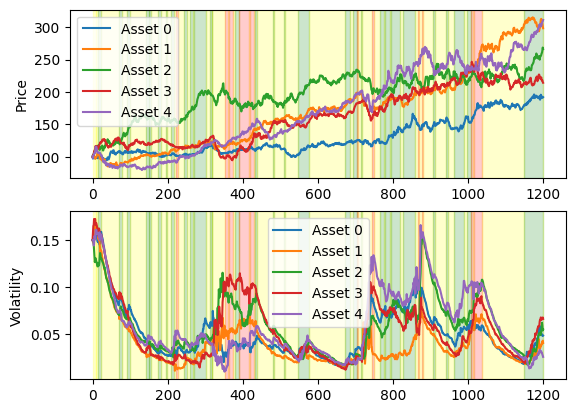

In [4]:
price_data_total = np.empty((T + T_test, a))
volatility_data_total = np.empty((T + T_test, a))

xi_values = [0.05, 0.2, 0.6] # volatility of volatility
kappa_values = [6, 1.0, 0.5] # mean reversion rate
theta_values = [0.01, 0.2, 1.2] # mean volatility
mu_values = [0.0, 1.0, -1.0] # price drift

V0 = np.full(a, 0.15)
S0 = np.full(a, 100)

price_data_total = np.empty((T + T_test, a))
volatility_data_total = np.empty((T + T_test, a))

fig, (ax1, ax2) = plt.subplots(2)

x_breakpoints = []
x_breakpoints_labels = []

t = 0
while t < T + T_test:
    this_regime = true_regimes_total[t]
    tt = t + 1
    while tt < T + T_test:
        if true_regimes_total[tt] == this_regime:
            tt += 1
        else:
            break
    x_breakpoints.append(tt)
    x_breakpoints_labels.append(this_regime)
    volatility_data_total[t:tt, :] = np.array([
            generate_volatility(
                V0=V0[i],
                xi=xi_values[this_regime],
                theta=theta_values[this_regime],
                kappa=kappa_values[this_regime],
                N=tt - t,
                dt=1/365
            )
            for i in range(a)
        ]).T
    price_data_total[t:tt, :] = np.array([
        generate_prices(
            vola_values=volatility_data_total[t:tt, i],
            S0=S0[i],
            N=tt - t,
            mu=mu_values[this_regime],
            dt=1/365
    )
        for i in range(a)
    ]).T
    V0 = volatility_data_total[tt - 1, :]
    S0 = price_data_total[tt - 1, :]
    t = tt

x_breakpoints_labels.append(this_regime)
x_breakpoints.append(t)

price_data = price_data_total[:T]
price_data_eval = price_data_total[T:]
volatility_data = volatility_data_total[:T]
volatility_data_data_eval = volatility_data_total[T:]

for i in range(a):
    ax1.plot(range(T + T_test), price_data_total[:, i], label=f"Asset {i}")
    ax2.plot(range(T + T_test), volatility_data_total[:, i], label=f"Asset {i}")

ax1.legend()
ax2.legend()
ax1.set_ylabel("Price")
ax2.set_ylabel("Volatility")

colors = ["green", "yellow", "red"]
color_labels = ["low vol", "medium vol", "high vol"]

for i in range(len(x_breakpoints) - 1):
    ax1.axvspan(x_breakpoints[i],
                x_breakpoints[i + 1], color=colors[x_breakpoints_labels[i]],
                alpha=0.2)
    ax2.axvspan(x_breakpoints[i],
                x_breakpoints[i + 1], color=colors[x_breakpoints_labels[i]],
                alpha=0.2)

true_regimes = true_regimes_total[:T]
true_regimes_eval = true_regimes_total[T:]

ax1.axvspan(0, x_breakpoints[0], color=colors[true_regimes[0]], alpha=0.2)
ax2.axvspan(0, x_breakpoints[0], color=colors[true_regimes[0]], alpha=0.2)

print(len(x_breakpoints_labels))

for c, cl in zip(colors, color_labels):
    print(f"color {c}: {cl}")

plt.show()

In [35]:
learning_rate = 0.1
discount_factor = 0.85
exp_eps_decay = 0.995 # multiply epsilon by this much every iteration
p = 30 # lookback period for sharpe ratio determination

eps = 1.0
Q = np.zeros((n, a))

W = np.empty((T, a))
state = 0

R = np.empty(T)
V = np.empty(T)

observed_returns = pd.DataFrame(price_data_total).pct_change(axis=0).to_numpy()
observed_returns[0, :] = np.zeros(a)
observed_volatility = np.empty((T, a))

# determine the thresholds for determining the regime (volatility based)
mean_returns = np.mean(observed_returns, axis=1)
print('mean returns:', mean_returns)
vola = pd.Series(mean_returns).rolling(p, min_periods=1).std().values
vola[0] = 0
print('vola:', vola)
vola_thresholds = np.quantile(vola, [0.33, 0.67])
print('vola thresholds:'); print(vola_thresholds)

state_distribution = np.zeros(n)

def get_new_state(thresholds, new_val):
    c = 0
    for v in thresholds:
        if new_val <= v:
            return c
        c += 1
    return c

for t in range(T):

    if np.random.uniform() <= eps:
        # choose randomly
        action_chosen = np.random.randint(0, a)
    else:
        # pick best action
        action_chosen = np.argmax(Q[state, :])

    W[t, :] = A[action_chosen, :]
    print('chosen action:', action_chosen, 'resulting in weights', W[t, :])
    R[t] = np.dot(W[t, :], observed_returns[t, :])
    print('resulting R:', R[t])
    print()
    observed_volatility[t, :] = np.std(observed_returns[max(0, t - p), :], axis=0)
    V[t] = np.std(R[max(0, t - p):t])
    sharpe = R[t] / max(0.01, V[t])

    next_state = get_new_state(vola_thresholds, V[t])
    state_distribution[next_state] += 1
    Q[state, action_chosen] = (
        (1 - learning_rate) * Q[state, action_chosen]
        +
        learning_rate * (sharpe + discount_factor * np.max(Q[next_state, :]))
    )
    eps *= exp_eps_decay

mean returns: [ 0.          0.00040956  0.01444464 ...  0.00648218 -0.00019064
 -0.00473561]
vola: [0.         0.0002896  0.00822394 ... 0.0047053  0.00471323 0.00480395]
vola thresholds:
[0.00437852 0.00611146]
chosen action: 1 resulting in weights [0.21485443 0.20617622 0.03965396 0.44735254 0.09196285]
resulting R: 0.0

chosen action: 0 resulting in weights [0.27355251 0.29642148 0.24905283 0.03833413 0.14263905]
resulting R: -0.0017815334414452034

chosen action: 1 resulting in weights [0.21485443 0.20617622 0.03965396 0.44735254 0.09196285]
resulting R: 0.012885526780246211

chosen action: 3 resulting in weights [0.5959723  0.32386518 0.0284747  0.01202313 0.03966469]
resulting R: -0.0010722515463254779

chosen action: 2 resulting in weights [0.03634625 0.12214351 0.64723516 0.18323714 0.01103793]
resulting R: 0.013935264712958995

chosen action: 4 resulting in weights [0.20017834 0.0241436  0.10147331 0.16152191 0.51268284]
resulting R: 0.008055764228360933

chosen action: 3 resu

C:\Users\tobia\AppData\Roaming\Python\Python311\site-packages\numpy\_core\_methods.py:222: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\tobia\AppData\Roaming\Python\Python311\site-packages\numpy\_core\_methods.py:180: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\tobia\AppData\Roaming\Python\Python311\site-packages\numpy\_core\_methods.py:214: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.011212034697494747

chosen action: 1 resulting in weights [0.21485443 0.20617622 0.03965396 0.44735254 0.09196285]
resulting R: 0.0017150206047891459

chosen action: 1 resulting in weights [0.21485443 0.20617622 0.03965396 0.44735254 0.09196285]
resulting R: 0.0033564267165658783

chosen action: 1 resulting in weights [0.21485443 0.20617622 0.03965396 0.44735254 0.09196285]
resulting R: 0.0017413877746871112

chosen action: 1 resulting in weights [0.21485443 0.20617622 0.03965396 0.44735254 0.09196285]
resulting R: -0.002015758864410325

chosen action: 1 resulting in weights [0.21485443 0.20617622 0.03965396 0.44735254 0.09196285]
resulting R: 0.008377923853605673

chosen action: 1 resulting in weights [0.21485443 0.20617622 0.03965396 0.44735254 0.09196285]
resulting R: 0.00575548962773208

chosen action: 1 resulting in weights [0.21485443 0.20617622 0.03965396 0.44735254 0.09196285]
resulting R: 0.012519089348927419

chosen action: 1 resulting in weights [0.21485443 0.20617622 0.03

[       nan 0.         0.00089077 0.00653481 0.00602498 0.00706638
 0.00656427 0.00700813 0.00775869 0.00829611 0.00787724 0.00758233
 0.00727573 0.00704764 0.0069571  0.0067563  0.00819104 0.00830639
 0.00833283 0.00813577 0.00793791 0.0086859  0.0085053  0.00894569
 0.00878966 0.00861248 0.00844644 0.00839047 0.00950083 0.00943647
 0.00927787 0.00930991 0.00932102 0.0094277  0.00967638 0.00994288
 0.01002135 0.0100886  0.01006481 0.00973122 0.00976661 0.01120831
 0.01130324 0.01144704 0.01148071 0.01161025 0.01090148 0.01060055
 0.01140091 0.01140116 0.01179055 0.01108764 0.01123364 0.0110612
 0.01111413 0.01115469 0.01113806 0.01117202 0.01040044 0.01049916
 0.01059108 0.01058009 0.01051341 0.01032194 0.01021518 0.009939
 0.00985338 0.0097884  0.00964298 0.00976638 0.00970006 0.00810204
 0.0083338  0.00834    0.00830616 0.00879797 0.00877106 0.00883714
 0.00779496 0.00779485 0.00726707 0.00733622 0.00748211 0.00746446
 0.00748889 0.00809149 0.00816078 0.00813397 0.00811088 0.0083752

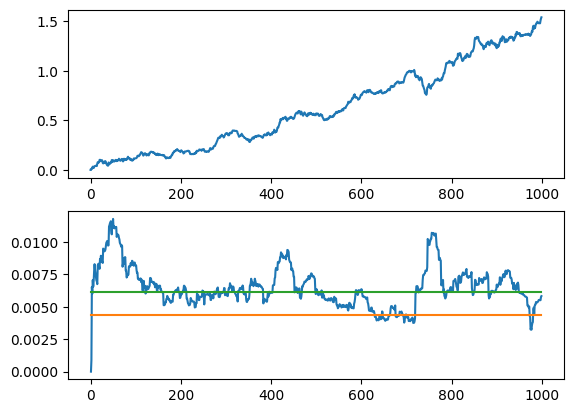

In [36]:
cum_returns = (1 + R).cumprod() - 1
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(cum_returns)
ax2.plot(V)
for h in vola_thresholds:
    ax2.plot(np.full(T, h))
print(V)
plt.show()

[ 78. 349. 573.]


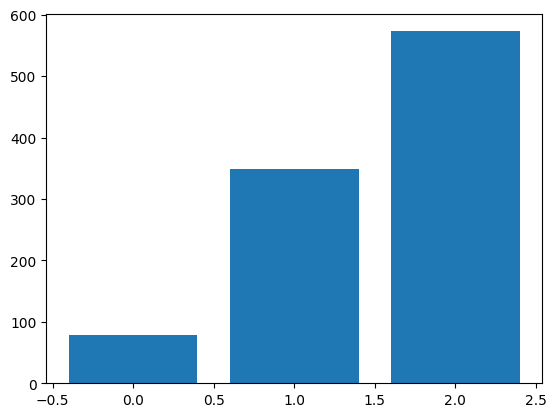

In [39]:
fig, ax = plt.subplots()
print(state_distribution)
ax.bar(x=range(3), height=state_distribution)
plt.show()